# NBA Shot Success Prediction Using Machine Learning
### A Court-Level Analysis of NBA Shots (2004–2024)
## Project Overview

This case study explores shot success prediction in the NBA using historical data from 2004 to 2024. A machine learning model (XGBoost Classifier) was trained on features like shot location, shot type, distance, and game time context to assign a predicted probability of a shot being made. The project is enhanced with rich visualizations and a Tableau dashboard for interactivity.

### Dataset Summary
  Source: NBA shots from 2004 to 2024

  Rows: ~4.2 million shots

   
Shout out to Dom Samangy for putting together such a cool data set:

    Samangy, D. (2024). NBA Shots 2004–2024 [Data set]. GitHub. https://github.com/DomSamangy/NBA_Shots_04_24



#### Check out the Tableau Dashboard I made for this: https://public.tableau.com/app/profile/christina.huynh1211/viz/NBAShotPredictor/NBAShotPredictor#3

## Step 1: Load & Explore Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split



In [2]:
df = pd.read_csv("NBA_2004_2024_Shots.csv")
#df.info()
#df.head()

In [3]:
# Show number of missing values per column
missing_values = df.isnull().sum()

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0]

# Display
print("Columns with missing values:")
print(missing_values)


Columns with missing values:
POSITION_GROUP    6823
POSITION          6823
dtype: int64


### **Key Observations:**
- The dataset contains **4.2M+ shot attempts** from **2004-2024**.
- Missing values exist in `POSITION_GROUP` and `POSITION`, but they are **not critical for shot analysis**.


## Step 2: Data Cleaning & Preprocessing

To prepare the dataset for analysis and modeling, I began by converting the GAME_DATE column into a proper datetime format to enable time-based filtering and visualization. I also cast the SHOT_MADE column into a binary integer format (1 for made shots, 0 for missed) to serve as the classification target. Then, I identified and addressed missing values—specifically dropping rows with nulls in key categorical features such as SHOT_TYPE and ACTION_TYPE, which are essential for both modeling and interpretation.

In [4]:
# Convert date and binary encode target
df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
df["SHOT_MADE"] = df["SHOT_MADE"].astype(int)
# Drop nulls in key columns
df.dropna(subset=["SHOT_TYPE", "ACTION_TYPE"], inplace=True)

## Step 3: Feature Engineering

For feature engineering, I selected a set of variables that I believed would be predictive of shot success, including spatial (LOC_X, LOC_Y, SHOT_DISTANCE), temporal (QUARTER, MINS_LEFT, SECS_LEFT), and categorical features (SHOT_TYPE, ACTION_TYPE, ZONE_NAME, ZONE_RANGE). I then applied one-hot encoding to the categorical variables using pd.get_dummies to convert them into a format suitable for modeling. The target variable, SHOT_MADE, was already cast to binary in the preprocessing step, making it ready for classification.

In [5]:
feature_cols = [
    "LOC_X", "LOC_Y", "SHOT_DISTANCE", "QUARTER", "MINS_LEFT", "SECS_LEFT",
    "SHOT_TYPE", "ACTION_TYPE", "ZONE_NAME", "ZONE_RANGE"
]
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df["SHOT_MADE"]

## Step 4: Train Machine Learning Model

To model shot success probability, I trained an XGBoost Classifier, a powerful gradient boosting algorithm commonly used for structured data. I split the data into training and testing sets using an 80/20 split. 

The model achieved an accuracy of 63.9% and an ROC AUC score of 0.67 on the test set. For a classification task like predicting NBA shot success—which depends on many subtle, unquantifiable variables like defender proximity, player fatigue, or in-game strategy—this level of accuracy is quite reasonable.

I did not optimize heavily for peak model accuracy, as the goal of this study was not to create a perfect prediction engine but to build a data-informed, interpretable tool that reflects real player tendencies and shot difficulty. 

A model that’s “too accurate” may overfit or rely on patterns that don’t generalize well, especially in a dynamic environment like basketball. Instead, I focused on producing realistic probabilities and insights that could be visualized and explored interactively.

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

/Users/christinahuynh/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6387888728311746
ROC AUC: 0.6735244461979585
              precision    recall  f1-score   support

           0       0.62      0.85      0.72    459142
           1       0.68      0.39      0.50    387111

    accuracy                           0.64    846253
   macro avg       0.65      0.62      0.61    846253
weighted avg       0.65      0.64      0.62    846253



#### Classification Report Interpretation

Class 0 represents missed shots, while class 1 represents made shots.

The model has a high recall for missed shots (0.85), meaning it's very good at identifying when a shot will be missed.

However, the recall for made shots is lower (0.39) — the model tends to be more cautious when predicting a make, likely due to class imbalance and the difficulty of capturing all factors that lead to a successful shot.

The precision for made shots (0.68) is relatively strong, meaning when the model predicts a shot will go in, it’s often correct.

The overall F1-score (0.50 for makes) reflects a balanced trade-off between precision and recall for makes, even if recall is the limiting factor.

## Step 5: Feature Importance

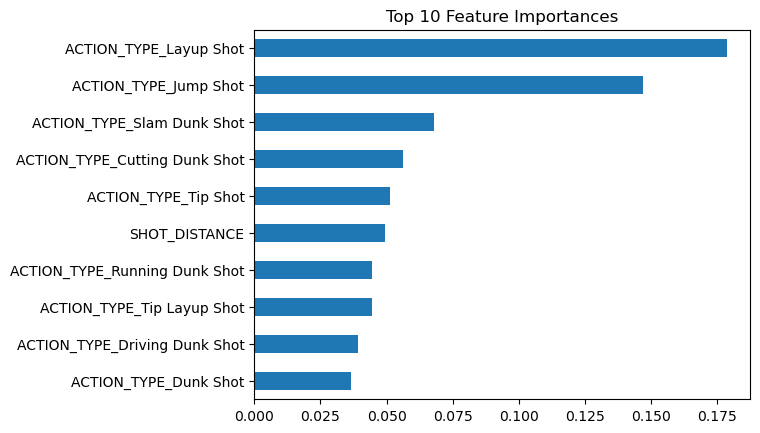

In [7]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

These insights reinforce that shot type (qualitative game context) can often be more informative than just location-based features, and justify including detailed categorical variables during feature engineering.

## Example Use Case: LeBron

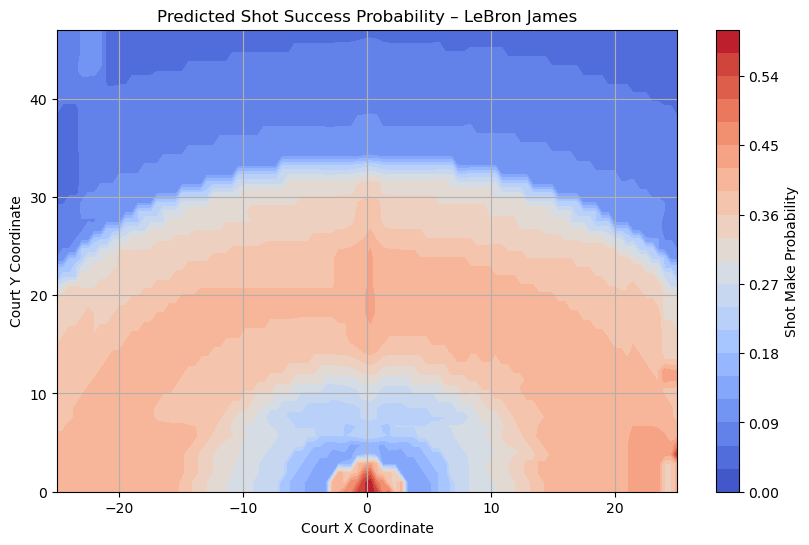

In [8]:
# Filter shots by player
player = "LeBron James"
player_data = df[df["PLAYER_NAME"] == player]

# Generate a grid of shot locations
x_range = np.linspace(-25, 25, 100)
y_range = np.linspace(0, 94, 100)
xx, yy = np.meshgrid(x_range, y_range)

# Flatten and create input features for prediction
shot_dist = np.sqrt(xx.ravel()**2 + yy.ravel()**2)
grid_features = pd.DataFrame({
    "LOC_X": xx.ravel(),
    "LOC_Y": yy.ravel(),
    "SHOT_DISTANCE": shot_dist,
    "QUARTER": 1,          # fixed values for simplicity
    "MINS_LEFT": 6,
    "SECS_LEFT": 0
})

# Merge with player’s most common shot type setup
most_common_zone = player_data["ZONE_RANGE"].mode()[0]
most_common_action = player_data["ACTION_TYPE"].mode()[0]
most_common_shot_type = player_data["SHOT_TYPE"].mode()[0]

grid_features["SHOT_TYPE"] = most_common_shot_type
grid_features["ACTION_TYPE"] = most_common_action
grid_features["ZONE_RANGE"] = most_common_zone
grid_features["ZONE_NAME"] = player_data["ZONE_NAME"].mode()[0]

# Encode features
grid_X = pd.get_dummies(grid_features)
# Match model columns (fill missing with 0s)
for col in model.feature_names_in_:
    if col not in grid_X:
        grid_X[col] = 0
grid_X = grid_X[model.feature_names_in_]

# Predict shot success probabilities
probs = model.predict_proba(grid_X)[:, 1].reshape(xx.shape)

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.title(f"Predicted Shot Success Probability – {player}")
heat = plt.contourf(xx, yy, probs, cmap="coolwarm", levels=20)
plt.colorbar(heat, label="Shot Make Probability")
plt.xlabel("Court X Coordinate")
plt.ylabel("Court Y Coordinate")
plt.ylim(0, 47)  # Optional: Half-court focus
plt.grid(True)
plt.show()


This heatmap visualizes the predicted probability of LeBron James making a shot from different areas of the half court.

#### 🔥 High Probability Zone (Red/Orange):

The area directly around the basket (especially in the paint and restricted area) shows the highest probability of a made shot. This aligns with LeBron’s well-known strength finishing at the rim.

#### 🧊 Low Probability Zone (Blue):

As distance from the basket increases (especially beyond the arc and deep perimeter), the model predicts a notable drop in shot success probability. This reflects the general difficulty of long-range shots and possibly LeBron’s historical shot data from those regions.

#### Symmetry & Shape:

The heatmap has a generally symmetrical arc shape, indicating the model has learned that distance from the hoop is a key driver of shot success, consistent with basketball fundamentals.



## Conclusion

This case study demonstrated how machine learning can be used to model and visualize NBA shot success probabilities using historical data from 2004–2024. By engineering meaningful features and applying an XGBoost classifier, I was able to predict the likelihood of a shot being made with reasonable accuracy (~64%) — a solid result given the natural randomness and nuance of in-game decision-making.


To demonstrate the model’s real-world utility, I generated player-specific shot success heatmaps. For example, LeBron James' heatmap revealed a high predicted success rate near the basket and a gradual decline as distance increases — consistent with both his playing style and general basketball shot difficulty. 

These visual insights not only validate the model's reasoning but also highlight how data-driven probability estimates can deepen player evaluation, strategy design, or even fan engagement.

Future enhancements could include incorporating defensive pressure, game context, or shot clock data to further enrich prediction quality.

## Export Data for Tableau Dashboard

In [9]:
df["SHOT_PROBABILITY"] = model.predict_proba(X)[:, 1]
tableau_df = df[[
    "PLAYER_NAME", "TEAM_NAME", "SEASON_1", "GAME_DATE",
    "LOC_X", "LOC_Y", "SHOT_DISTANCE", "SHOT_TYPE", "ACTION_TYPE",
    "ZONE_NAME", "ZONE_RANGE", "SHOT_MADE", "SHOT_PROBABILITY"
]]
tableau_df.to_csv("nba_shot_predictions_tableau.csv", index=False)